References:
https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/

https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/

https://learnopencv.com/introduction-to-generative-adversarial-networks/

https://github.com/safwankdb
https://github.com/tooth2/Handwritten-digits-generation/blob/main/MNIST_GAN.ipynb

In [1]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
# from model import Model
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.ToTensor(),
                transforms.Normalize((0.5),(0.5))
                ])
to_image = transforms.ToPILImage()


In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

In [6]:
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

In [7]:
print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


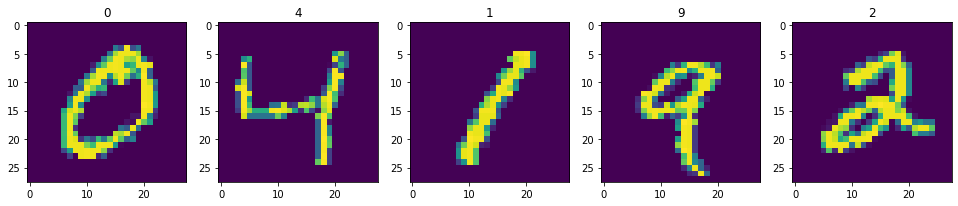

In [8]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()

In [9]:
from torch.nn.modules import dropout
import torch.nn as nn
class Model(nn.Module):
    def __init__(self,out_1=32,out_2=64):
        
        super(Model,self).__init__()
        #first Convolutional layers 
        self.cnn1=nn.Conv2d(in_channels=1,out_channels=out_1,kernel_size=3,padding=1)
        self.maxpool1=nn.MaxPool2d(kernel_size=2 ,stride=2)

        #second Convolutional layers
        self.cnn2=nn.Conv2d(in_channels=out_1,out_channels=out_2,kernel_size=3,stride=1,padding=1)
        self.maxpool2=nn.MaxPool2d(kernel_size=2 ,stride=2)
        #max pooling 

        #fully connected layer 
        self.fc1=nn.Linear(out_2*7*7,128)
        self.fc2=nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self,x):
        #first Convolutional layers
        x=self.cnn1(x)
        #activation function 
        x=torch.relu(x)
        #max pooling 
        x=self.maxpool1(x)
        #first Convolutional layers
        x=self.cnn2(x)
        #activation function
        x=torch.relu(x)
        #max pooling
        x=self.maxpool2(x)

        x = x.reshape(x.size(0), -1)
        #flatten output 
        x=x.view(x.size(0),-1)
        #fully connected layer
        x=self.fc1(x)
        x=torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def activations(self,x):
        #outputs activation this is not necessary just for fun 
        z1=self.cnn1(x)
        a1=torch.relu(z1)
        out=self.maxpool1(a1)
        
        z2=self.cnn2(out)
        a2=torch.relu(z2)
        out=self.maxpool2(a2)
        out=out.view(out.size(0),-1)
        return z1,a1,z2,a2,out  

model=Model()
print(model)  

Model(
  (cnn1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
model = Model().to(device)

criterion=nn.CrossEntropyLoss()

learning_rate=0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


n_epochs=100
train_cost=[]
val_cost=[]
accuracy_list=[]
N_val=len(mnist_valset)
cost1=0
cost2 =0

for epoch in range(n_epochs):
    cost1=0    
    for x, y in train_dataloader:
      
        x = x.to(device)
        y = y.to(device)

        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z=model(x)
        # calculate loss 
        loss=criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        cost1+=loss.item()
    train_cost.append(cost1)
        
        
    correct=0
    #perform a prediction on the validation  data  
    for x_val, y_val in val_dataloader:
        cost2=0
        x_val = x_val.to(device)
        y_val = y_val.to(device)

        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z_val=model(x_val)
        # calculate loss 
        loss=criterion(z_val,y_val)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        cost2+=loss.item()
        _,yhat=torch.max(z_val.data,1)

        correct+=(yhat==y_val).sum().item()
        
    val_cost.append(cost2)

    accuracy=correct/N_val

    accuracy_list.append(accuracy)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, n_epochs, cost1, cost2, accuracy))

In [11]:
torch.save(model.state_dict(), "model.pth")

In [12]:
len(val_cost)
len(train_cost)

0

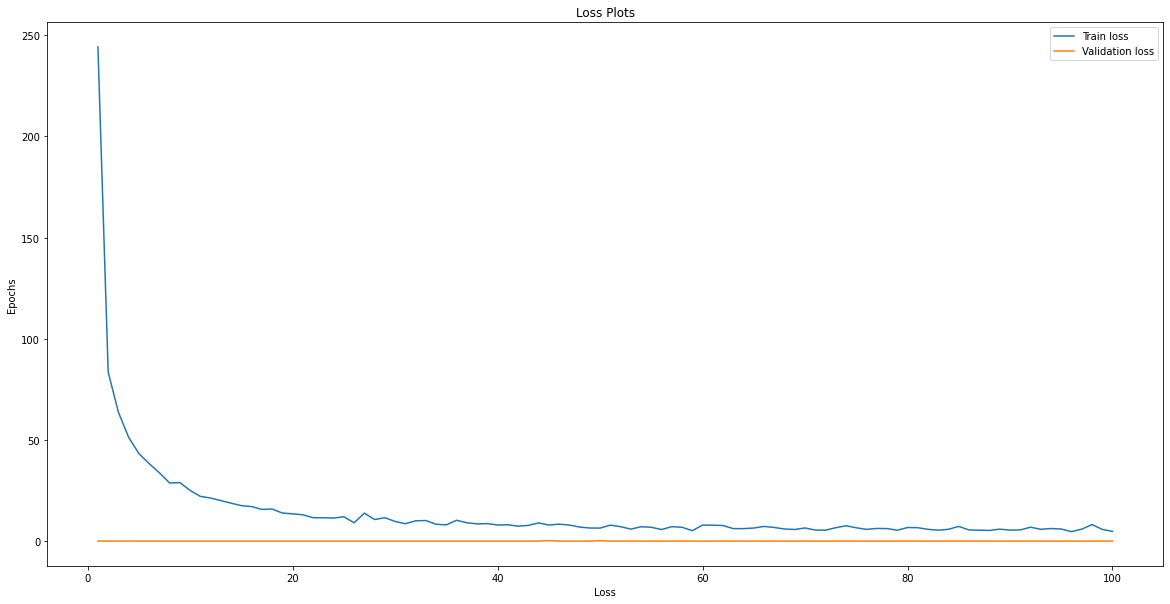

In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, (n_epochs)+1), train_cost, label="Train loss")
plt.plot(np.arange(1, (n_epochs)+1), val_cost, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
# test model
model.load_state_dict(torch.load("model.pth"))
model.eval()

results = list()
correct=0
accuracy = []
N_test=len(mnist_testset)

for image, label in test_dataloader:

    image = image.to(device)
    label = label.to(device)

    pred = model(image)

    _,yhat=torch.max(pred.data,1)

    correct+=(yhat==label).sum().item()

    acc=correct/N_test

    accuracy.append(acc)

print('Test accuracy {:.8f}'.format(accuracy[-1]))

references:
https://github.com/iamkrut/MNIST_handwriting_classification

https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9

